In [16]:
import torch
import torch.nn.functional as F
import pandas
import torchaudio
import torchaudio.transforms as T
import os
from tqdm import tqdm
from datasets import load_dataset,Audio
import numpy as np
import soundata
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from ..src.utils.datasets import UrbanSound8k,GTZAN,CommonVoiceDataset,TimitDataset
#from sklearn.model_selection import train_test_split
torchaudio.set_audio_backend("soundfile")

In [20]:
from torchmetrics import Metric
from torch import Tensor
class ExpectedCost(Metric):
    """
    Wrapper on the expected cost as defined in https://github.com/luferrer/expected_cost
    """
    def __init__(self,task = "binary", costs=None, priors=None, sample_weight=None, adjusted=False,num_classes = 2):
        super().__init__()
        self.conf = ConfusionMatrix(task=task,num_classes=num_classes)
        if costs is None:
            
            costs = 1-torch.eye(num_classes)
            
            self.costs = costs
        else:
            self.costs = costs
        self.priors = priors
        self.sample_weight = sample_weight
        self.adjusted=adjusted
        self.num_classes = num_classes
        
            
        self.add_state("bincounts", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("matrix", default=torch.zeros((num_classes,num_classes)), dist_reduce_fx="sum")
        
    def _input_format(self,preds,target):
        return preds,target
    def update(self, preds: Tensor, target: Tensor):
        preds, target = self._input_format(preds, target)
        
        assert preds.shape == target.shape
        self.matrix = self.conf(preds,target)
        
        self.bincounts = torch.bincount(target,minlength=self.num_classes)
        
    def compute(self):
        self.matrix = self.matrix/self.matrix.sum(axis=1, keepdims=True)
        priors = (self.bincounts/self.bincounts.sum()).unsqueeze(0).T
        if self.adjusted:
            # When adjusted is true, normalize the average cost
            # with the cost of a naive system that always makes
            # the min cost decision.
            norm_value = torch.min(torch.dot(priors.T, self.costs))
        else:
            norm_value = 1.0
                
        ave_cost = torch.sum(priors * self.costs * self.matrix)

        return ave_cost / norm_value

## Datasets

In [11]:
noise_test = UrbanSound8k(mode="test")

100%|██████████| 8732/8732 [01:24<00:00, 103.20it/s]  


In [4]:
music_test = GTZAN(csv_file="features_3_sec.csv",root_dir="/lium/raid01_b/tmario/phD/data/gtzan/",mode="eval",overwrite=False)

In [5]:
gender_test = CommonVoiceDataset(mode="test")

Cleaning.......OK


In [6]:
phone_test = TimitDataset(mode="test")

Cleaning.......OK
Dataset preparation


## Load NMF-based multilabel segmentation model

In [8]:
import yaml
from pyannote.audio import Model

w_nmf = torch.load("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/dict/W_win_1024_nfft_1024_256_beta_2_mu_1_AragonRadio_sp_200_mus_500_no_500_max_seg_4.pt")
with open("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/config_wavlm.yaml","rb") as fh:
    cfg = yaml.safe_load(fh)
model = Model.from_pretrained("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/3MASNMF/make_it_sparser_256/X.Segmentation.Full_WP2-make_it_sparser_256-10.0-5.0-0.1-augTrue/models/23_12_12.ckpt",
                              w_nmf=w_nmf,
                              wavlm_cfg=cfg["model"]["wavlm"],
                              spec_kw={"win_length":1024, "hop_length":320,"n_fft":1024})
model.freeze()

Type of NMF matrix: <class 'torch.Tensor'> torch.Size([513, 256])


Using cache found in /lium/home/mlebour/.cache/torch/hub/s3prl_s3prl_main


### Classifier instance

In [27]:
class LinProbe(torch.nn.Module):
    
    def __init__(self,input_size=256,output_size=10,agreg = "mean_std"):
        super().__init__()
        self.agreg = agreg
        weight = 1 if agreg in ["mean","std"] else 2
        
        self.probe = torch.nn.Sequential(torch.nn.Linear(weight*input_size,output_size))
    
    def forward(self,x):
        x_mean = None
        x_std = None
        if "mean" in self.agreg:
            x_mean = x.mean(dim=1)
        if "std" in self.agreg:
            x_std = x.std(dim=1)
        if x_mean is not None and x_std is not None:
            input_x = torch.cat([x_mean,x_std],dim=-1)
        elif x_mean is not None:
            input_x = x_mean
        elif x_std is not None:
            input_x = x_std
        
        y = self.probe(input_x)
        
        return y

## Train 

In [28]:
from tqdm import tqdm

def train_epoch(seg_model,classif_probe,dataloader,loss_fun,optimizer,device="cpu"):
    avg_loss=0
    last_avg_loss=0
    for batch_idx, (data,label) in enumerate(tqdm(dataloader)):    
        optimizer.zero_grad()
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))
        
        loss = loss_fun(logits,label.to(device))
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
        if batch_idx%10 == 0:
            avg_loss/=10
            last_avg_loss=avg_loss
            print(f"Train loss: {avg_loss}")
            avg_loss=0
        
    return classif_probe, last_avg_loss

def valid_epoch(seg_model,classif_probe,dataloader,loss_fun,device="cpu"):
    valid_loss=0.0
    for batch_idx, (data, label) in enumerate(tqdm(dataloader,desc="Validation")):        
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))   
        
        valid_loss += loss_fun(logits,label.to(device))
        
    return valid_loss/(batch_idx+1)

In [38]:
n_epoch = 50

# classif_probe = LinProbe(input_size=256,output_size=10,agreg="mean")
# music_train = music_test = GTZAN(csv_file="features_3_sec.csv",root_dir="/lium/raid01_b/tmario/phD/data/gtzan/",mode="train",overwrite=False)
# music_valid = music_test = GTZAN(csv_file="features_3_sec.csv",root_dir="/lium/raid01_b/tmario/phD/data/gtzan/",mode="valid",overwrite=False)
# train_loader= DataLoader(music_train, batch_size=128, shuffle=True,num_workers=10)
# valid_loader = DataLoader(music_valid, batch_size=128, shuffle=False,num_workers=10)

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(classif_probe.parameters(),lr=0.01)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model.to(device)
# classif_probe.to(device)

# best_valid = 1e8

# train_loss = []
# valid_loss = []
for epoch in range(1,n_epoch+1):
    print(f"Epoch {epoch}")
    classif_probe, train_loss_t = train_epoch(seg_model=model,classif_probe=classif_probe,dataloader=train_loader,loss_fun=loss_fn,optimizer=optimizer,device=device)
    valid_loss_t = valid_epoch(seg_model=model,classif_probe=classif_probe,dataloader=valid_loader,loss_fun=loss_fn,device=device)
    
    
    train_loss.append(train_loss_t)
    valid_loss.append(valid_loss_t)
    print(f"Validation loss = {valid_loss}")
    if valid_loss_t < best_valid:
        torch.save(classif_probe.state_dict(), "probes/sparse_music_probe_256_mean.pt")
        best_valid = valid_loss_t
    

Epoch 1


  2%|▏         | 1/57 [00:03<02:50,  3.05s/it]

Train loss: 0.12552934885025024


 19%|█▉        | 11/57 [00:19<01:16,  1.66s/it]

Train loss: 1.4565739631652832


 37%|███▋      | 21/57 [00:36<00:59,  1.66s/it]

Train loss: 1.485206961631775


 54%|█████▍    | 31/57 [00:52<00:43,  1.67s/it]

Train loss: 1.3756366968154907


 72%|███████▏  | 41/57 [01:09<00:26,  1.68s/it]

Train loss: 1.4662398099899292


 89%|████████▉ | 51/57 [01:26<00:10,  1.68s/it]

Train loss: 1.4510389566421509


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:48,  3.00s/it]

Train loss: 0.14617912471294403


 19%|█▉        | 11/57 [00:19<01:18,  1.70s/it]

Train loss: 1.4548109769821167


 37%|███▋      | 21/57 [00:36<01:01,  1.70s/it]

Train loss: 1.4331587553024292


 54%|█████▍    | 31/57 [00:53<00:44,  1.70s/it]

Train loss: 1.4215689897537231


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.4255316257476807


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.4603885412216187


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:48,  3.01s/it]

Train loss: 0.16268528997898102


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.48146390914917


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4793680906295776


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.4786690473556519


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.3535531759262085


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.3665876388549805


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:49,  3.03s/it]

Train loss: 0.13369250297546387


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.4130972623825073


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4257957935333252


 54%|█████▍    | 31/57 [00:54<00:44,  1.72s/it]

Train loss: 1.3881937265396118


 72%|███████▏  | 41/57 [01:11<00:27,  1.71s/it]

Train loss: 1.4126251935958862


 89%|████████▉ | 51/57 [01:28<00:10,  1.71s/it]

Train loss: 1.3685458898544312


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:48,  3.00s/it]

Train loss: 0.13038115203380585


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.4250913858413696


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4900869131088257


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.5508761405944824


 72%|███████▏  | 41/57 [01:11<00:27,  1.71s/it]

Train loss: 1.4817146062850952


 89%|████████▉ | 51/57 [01:28<00:10,  1.71s/it]

Train loss: 1.4822348356246948


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:53,  3.10s/it]

Train loss: 0.17146269977092743


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.4461297988891602


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.3518966436386108


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.454175353050232


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.549406886100769


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.45100998878479


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:50,  3.05s/it]

Train loss: 0.17032009363174438


 19%|█▉        | 11/57 [00:20<01:18,  1.72s/it]

Train loss: 1.5051116943359375


 37%|███▋      | 21/57 [00:37<01:01,  1.70s/it]

Train loss: 1.4363259077072144


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.6052826642990112


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.5541901588439941


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.4407875537872314


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:50,  3.04s/it]

Train loss: 0.1173582598567009


 19%|█▉        | 11/57 [00:20<01:18,  1.71s/it]

Train loss: 1.3164180517196655


 37%|███▋      | 21/57 [00:37<01:01,  1.70s/it]

Train loss: 1.3685476779937744


 54%|█████▍    | 31/57 [00:54<00:44,  1.70s/it]

Train loss: 1.4123538732528687


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.4798222780227661


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.4506105184555054


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:02<02:46,  2.98s/it]

Train loss: 0.1778641939163208


 19%|█▉        | 11/57 [00:20<01:18,  1.72s/it]

Train loss: 1.6071306467056274


 37%|███▋      | 21/57 [00:37<01:01,  1.70s/it]

Train loss: 1.5122216939926147


 54%|█████▍    | 31/57 [00:54<00:44,  1.70s/it]

Train loss: 1.4245953559875488


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.462090015411377


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.3501991033554077


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:50,  3.04s/it]

Train loss: 0.17849193513393402


 19%|█▉        | 11/57 [00:20<01:18,  1.72s/it]

Train loss: 1.5302646160125732


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4391429424285889


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.3682693243026733


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.4122651815414429


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.3997881412506104


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:48,  3.02s/it]

Train loss: 0.15377886593341827


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.3856875896453857


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.3371517658233643


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.4024041891098022


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.4207251071929932


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.3621004819869995


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:51,  3.06s/it]

Train loss: 0.1320587694644928


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.4375874996185303


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.5033754110336304


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.4978777170181274


 72%|███████▏  | 41/57 [01:11<00:27,  1.71s/it]

Train loss: 1.525952696800232


 89%|████████▉ | 51/57 [01:28<00:10,  1.71s/it]

Train loss: 1.4665155410766602


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:49,  3.02s/it]

Train loss: 0.1403115838766098


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.496091604232788


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4897054433822632


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.3946011066436768


 72%|███████▏  | 41/57 [01:11<00:27,  1.71s/it]

Train loss: 1.4889806509017944


 89%|████████▉ | 51/57 [01:28<00:10,  1.71s/it]

Train loss: 1.3973350524902344


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:52,  3.07s/it]

Train loss: 0.13034789264202118


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.393500804901123


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.4031879901885986


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.3989852666854858


 72%|███████▏  | 41/57 [01:11<00:27,  1.70s/it]

Train loss: 1.449318766593933


 89%|████████▉ | 51/57 [01:28<00:10,  1.70s/it]

Train loss: 1.5709151029586792


Validation: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Validation loss = [tensor(1.8563, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7085, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8367, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6290, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6546, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6288, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4934, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4674, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5490, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8506, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4970, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7092, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6074, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.4997, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6789, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.5519, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.461

  2%|▏         | 1/57 [00:03<02:49,  3.02s/it]

Train loss: 0.14082536101341248


 19%|█▉        | 11/57 [00:20<01:19,  1.72s/it]

Train loss: 1.6441137790679932


 37%|███▋      | 21/57 [00:37<01:01,  1.71s/it]

Train loss: 1.508102297782898


 54%|█████▍    | 31/57 [00:54<00:44,  1.71s/it]

Train loss: 1.4198850393295288


 54%|█████▍    | 31/57 [00:56<00:46,  1.81s/it]


KeyboardInterrupt: 

In [12]:
noise_loader = DataLoader(noise_test, batch_size=128, shuffle=False,num_workers=10)
music_loader = DataLoader(music_test, batch_size=128, shuffle=False,num_workers=10)
gender_loader = DataLoader(gender_test, batch_size=64, shuffle=False,num_workers=10)
phone_loader = DataLoader(phone_test, batch_size=128, shuffle=False,num_workers=10)

In [39]:
# ckpt_music = torch.load("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/probes/mean_music_style_lin_probe.pt")
ckpt_music = torch.load("./probes/sparse_music_probe_256_mean.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classif_probe_music = LinProbe(input_size=256,output_size=10,agreg='mean')
classif_probe_music.load_state_dict(ckpt_music)
classif_probe_music.to(device)
model.to(device)
print("Done")

Done


In [13]:
ckpt_noise = torch.load("./probes/sparse_noise_probe_256_mean.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classif_probe_noise = LinProbe(input_size=256,output_size=10,agreg='mean')
classif_probe_noise.load_state_dict(ckpt_noise)
classif_probe_noise.to(device)
model.to(device)
print("Done")

NameError: name 'ckpt' is not defined

In [40]:
pred = []
lab = []
model.to(device)
classif_probe_music.to(device)
for batch_idx, (data,label) in enumerate(tqdm(music_loader)):    

    with torch.no_grad():
        feat = model.wavlm(data.to(device))
        emb = model.emb_transform(feat)
        lab.extend(label.detach().cpu().numpy())
        
        logits = classif_probe_music(emb.permute(0,2,1))
        #print(logits.shape)
        pred.extend(logits.argmax(dim=-1).detach().cpu().numpy())

        

100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


In [41]:
from torchmetrics import F1Score,Accuracy,ConfusionMatrix,Recall
nclasses = 10
f1 = F1Score(task="multiclass",num_classes=nclasses,average="macro")
recall = Recall(task="multiclass",num_classes=nclasses,average="macro")
acc = Accuracy(task='multiclass',num_classes=nclasses)
conf = ConfusionMatrix(task='multiclass',num_classes=nclasses)
ecp = ExpectedCost(task="multiclass",num_classes=nclasses)

In [42]:
tpred = torch.from_numpy(np.array(pred))
tlabel = torch.from_numpy(np.array(lab))

In [43]:
import numpy as np

#print("0 Male, 1 Female")

print("Acc =",acc(tpred,tlabel))
print("F1score =",f1(tpred,tlabel))
print("UAR =",recall(tpred,tlabel))
#print("\nCUSTOM EC")
print("Expected cost",ecp(tpred,tlabel))
print("Acc from EC",1-ecp(tpred,tlabel))


Acc = tensor(0.5506)
F1score = tensor(0.5450)
UAR = tensor(0.5509)
Expected cost tensor(0.4494)
Acc from EC tensor(0.5506)


In [18]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

In [44]:
classes = music_test.get_classes()

<Axes: >

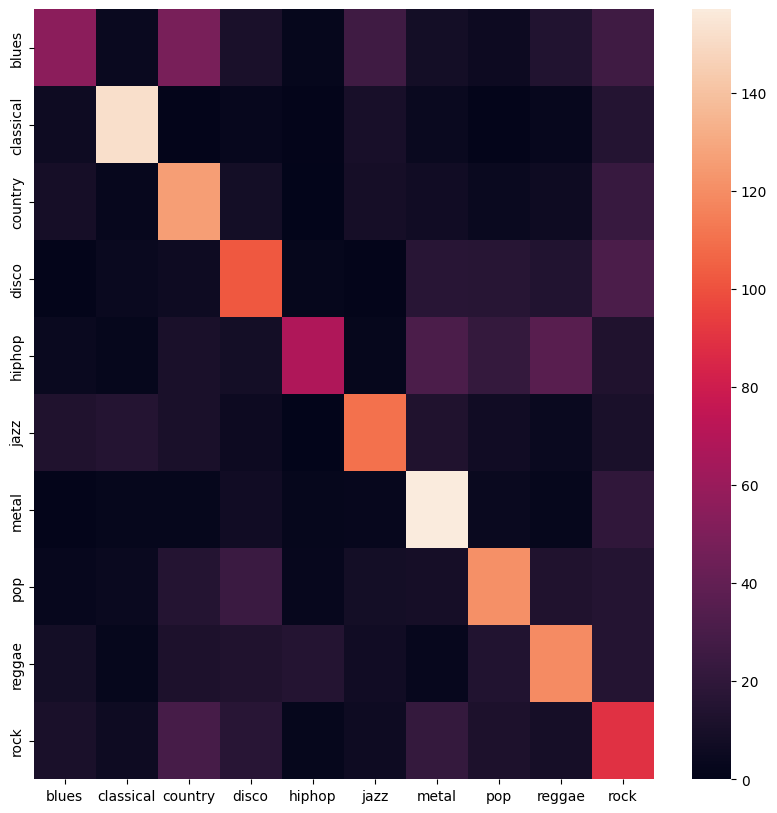

In [45]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(conf(tpred,tlabel),xticklabels=classes,yticklabels=classes)

torch.Size([512])


<Axes: >

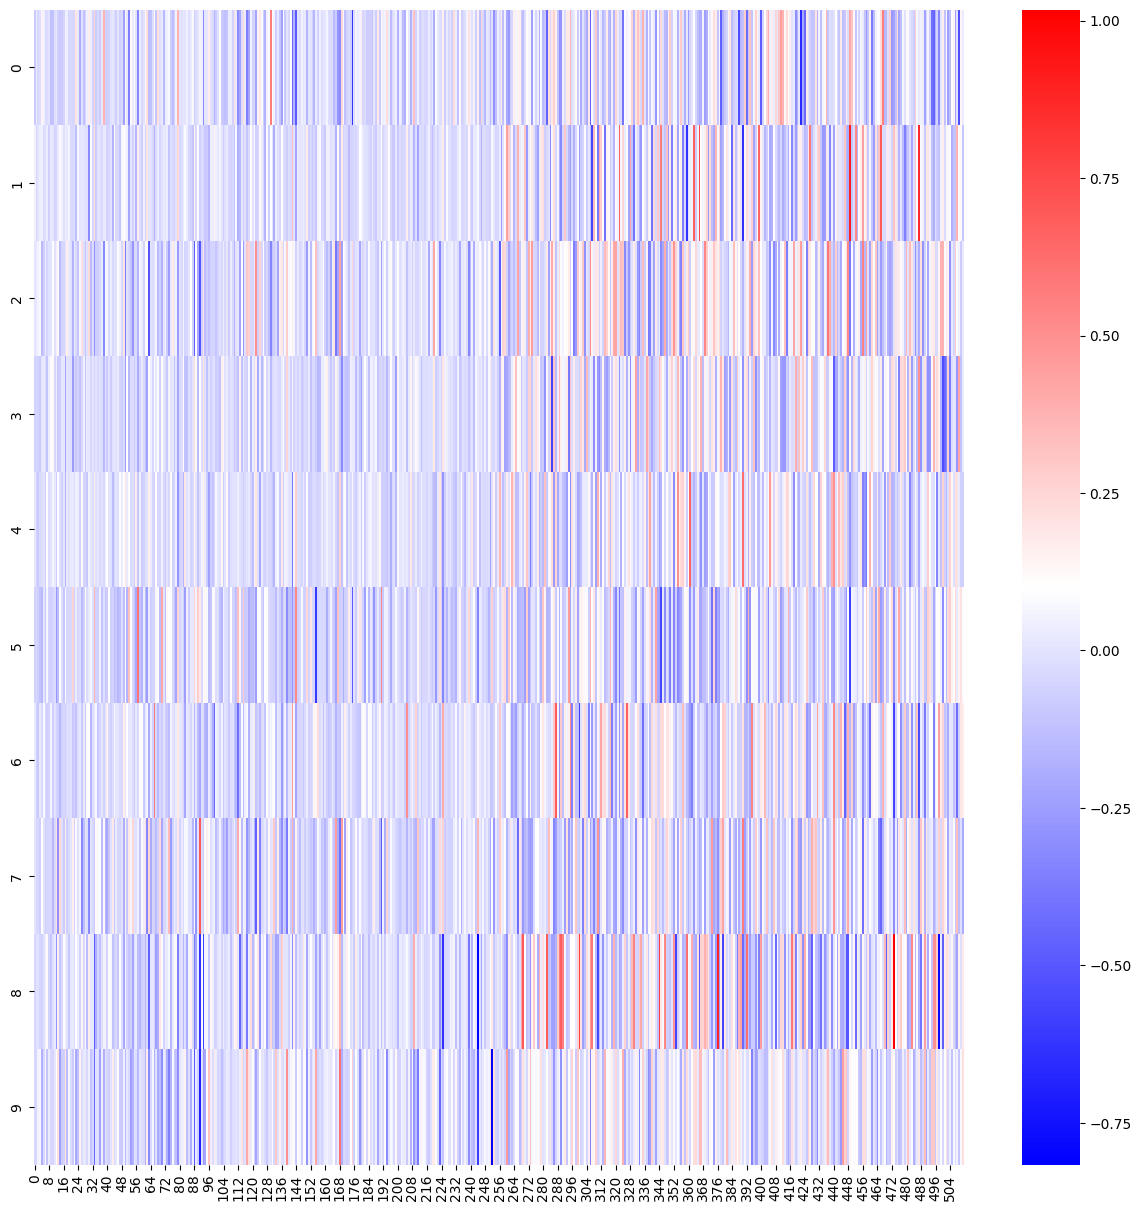

In [20]:
plt.figure(figsize=(15,15))
print(ckpt['probe.0.weight'].cpu()[0].shape)

sn.heatmap(ckpt['probe.0.weight'].cpu(),cmap='bwr')